# Spotify - All Time Top 2000s Mega Dataset
by: Bondoc, Alyana; Dalisay, Andres; To, Justin

We will be using the dataset [Spotify - All Time Top 2000s Mega Dataset](https://www.kaggle.com/datasets/iamsumat/spotify-top-2000s-mega-dataset) for this project. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

%load_ext autoreload
%autoreload 2

## The Dataset

The dataset consists of a list of the top tracks to have come out between 1956 and 2019 that are available on Spotify. It contains information about the track and how it scales across multiple sound features. The dataset was extracted from the playlist, “Top 2000s”, on Spotify. The data was then passed to PlaylistMachinery(@plamere), which was then able to retrieve attributes per song in the playlist. Sumat Singh then scraped the data from the site using Python with Selenium to form the dataset that the group will be using for the analysis.

The dataset contains 15 different columns that represent an attribute as well as 1995 different rows wherein 1994 of them represent an observation with 1 representing the column names, thus giving it a shape of (1995,15).

The column/variables consist of: 

- **`Title`**: Title of the track.
- **`Artist`**: Artist/group who made the track.
- **`Top Genre`**: Genre of the track.
- **`Year`**: Year the track was released.
- **`Length`**: Duration of the track in seconds.
- **`Beats Per Minute`**: Average count of beats per 1 minute interval of the track.
- **`Energy`**: Scale measuring how energetic and upbeat the track is. The higher the value, the more energetic.
- **`Danceability`**: Scale measuring how usable the track is for dancing. The higher the value, the more danceable.
- **`Loudness`**: Scale measuring how loud the track is, measured in decibels. The higher the value, the louder.
- **`Valence`**: Scale measuring the mood of the song, whether it be positive or negative. The higher the value, the more positive.
- **`Accoustic`**: Scale measuring how acoustic the track is. The higher the value, the more acoustic.
- **`Speechiness`**: Scale measuring the track’s word count. The higher the value, the more words were used.
- **`Liveliness`**: Scale measuring the likeliness that it is a live recording. The higher the value, the more likely it is that the track was recorded live.
- **`Popularity`**: Scale measuring how popular the song is. The higher the value, the more popular the song is as of 2019.

All of this data was taken by PlaylistMachinery from the Spotify API. More detailed descriptions of the audio features can be seen in [Spotify's Web API Documentation.](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

The dataset was provided as a `.csv` file.

In [2]:
df = pd.read_csv("Spotify-2000.csv")
df

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,1990,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63
1990,1991,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69
1991,1992,Johnny B. Goode,Chuck Berry,blues rock,1959,168,80,53,-9,31,97,162,74,7,74
1992,1993,Take Five,The Dave Brubeck Quartet,bebop,1959,174,26,45,-13,7,60,324,54,4,65


In [3]:
df.describe()

,Index,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Acousticness,Speechiness,Popularity
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.00000
mean,997.500000,1992.992979,120.215647,59.679539,53.238215,-9.008526,19.012036,49.408726,28.858074,4.994985,59.52658
std,575.762538,16.116048,28.028096,22.154322,15.351507,3.647876,16.727378,24.858212,29.011986,4.401566,14.35160
min,1.000000,1956.000000,37.000000,3.000000,10.000000,-27.000000,2.000000,3.000000,0.000000,2.000000,11.00000
25%,499.250000,1979.000000,99.000000,42.000000,43.000000,-11.000000,9.000000,29.000000,3.000000,3.000000,49.25000
50%,997.500000,1993.000000,119.000000,61.000000,53.000000,-8.000000,12.000000,47.000000,18.000000,4.000000,62.00000
75%,1495.750000,2007.000000,136.000000,78.000000,64.000000,-6.000000,23.000000,69.750000,50.000000,5.000000,71.00000
max,1994.000000,2019.000000,206.000000,100.000000,96.000000,-2.000000,99.000000,99.000000,99.000000,55.000000,100.00000


Let's check the data types of the variables.

In [4]:
print(df.dtypes);

Index                      int64
Title                     object
Artist                    object
Top Genre                 object
Year                       int64
Beats Per Minute (BPM)     int64
Energy                     int64
Danceability               int64
Loudness (dB)              int64
Liveness                   int64
Valence                    int64
Length (Duration)         object
Acousticness               int64
Speechiness                int64
Popularity                 int64
dtype: object


## Cleaning the Dataset

Before we can start exploring our dataset, we had to first preprocess the data by cleaning and formatting it into a more usable and ideal form.

First, let's check if there are any null values in the dataset that need to be taken care of.

In [5]:
df.isnull().values.any()

False

We can conclude there aren't any missing or null values in our dataset.

Let us then look for duplicate values in the dataset, and if there are, understand the context behind them and decided on how to deal with them.

The field that requires investigation is the `Title`, as it is the one that is commonly used to identify its record.

In [6]:
df['Title'].value_counts()

One                                          3
Feeling Good                                 3
Hallelujah                                   3
Suzanne                                      2
Memories                                     2
                                            ..
Once Upon a Time in the West - Main Theme    1
Bridges                                      1
You Want It Darker                           1
Dark Necessities                             1
Blueberry Hill                               1
Name: Title, Length: 1958, dtype: int64

As we can see here, we have detected multiple iterations of certain track `Titles`. Let's investigate further by including the `Artist's` name in the value count.

In [7]:
(df['Title']+" "+df['Artist']).value_counts()

Sunrise Norah Jones                         1
Eye of the Tiger Survivor                   1
In Between Days - 2006 Remaster The Cure    1
Greatest Love of All Whitney Houston        1
Josephine Chris Rea                         1
                                           ..
You Want It Darker Leonard Cohen            1
Dark Necessities Red Hot Chili Peppers      1
Million Years Ago Adele                     1
Lazarus David Bowie                         1
Blueberry Hill Fats Domino                  1
Length: 1994, dtype: int64

Thus, we conclude that the duplicate entities in the title field actually belong to different `Artists`. With that said, we can also say that there are no duplicate song entries in the database

Now, we are going to be looking at categorical values to see if they happen to have duplicate iterations.

The two columns that contain categorical values are `Year` and `Top Genre`

In [8]:
print(df['Year'].value_counts())

2008    54
1991    52
2018    52
1977    51
2002    47
        ..
1962     3
1959     3
1961     1
1960     1
1956     1
Name: Year, Length: 63, dtype: int64


We can see that there aren't really any categorical duplicates or different iterations of similar categorical values for the field `Year`

In [9]:
print(df['Top Genre'].value_counts())

album rock           413
adult standards      123
dutch pop             88
alternative rock      86
dance pop             83
                    ... 
streektaal             1
indie anthem-folk      1
la pop                 1
ccm                    1
bebop                  1
Name: Top Genre, Length: 149, dtype: int64


We can see that there also aren't really any categorical duplicates or different iterations of similar categorical values for the field `Top Genre`

Next, we want to convert each column name into snake_case format so that it'll be much easier to refer to them in our code.

In [10]:
list(df.columns)

['Index',
 'Title',
 'Artist',
 'Top Genre',
 'Year',
 'Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Length (Duration)',
 'Acousticness',
 'Speechiness',
 'Popularity']

In [11]:
df.rename(columns = {
    'Index':'index',
    'Title': 'title',
    'Artist': 'artist',
    'Top Genre': 'top_genre',
    'Year': 'year',
    'Beats Per Minute (BPM)': 'bpm',
    'Energy': 'energy',
    'Danceability': 'danceability',
    'Loudness (dB)': 'loudness',
    'Liveness': 'liveness',
    'Valence': 'valence',
    'Length (Duration)': 'length',
    'Acousticness': 'acousticness',
    'Speechiness': 'speechiness',
    'Popularity': 'popularity'
}, inplace=True)

list(df.columns)

['index',
 'title',
 'artist',
 'top_genre',
 'year',
 'bpm',
 'energy',
 'danceability',
 'loudness',
 'liveness',
 'valence',
 'length',
 'acousticness',
 'speechiness',
 'popularity']

Looking at the datatypes of each column, the `title`, `artist`, `top_genre`, and `length` columns all had the Object datatype, while the rest of the columns had proper datatypes as integers.

In [12]:
print(df.dtypes);

index            int64
title           object
artist          object
top_genre       object
year             int64
bpm              int64
energy           int64
danceability     int64
loudness         int64
liveness         int64
valence          int64
length          object
acousticness     int64
speechiness      int64
popularity       int64
dtype: object


The former three mentioned were converted into Strings, while the `length` column had to be converted into integers. However, the `length` column had some values with 4 digits that were formatted with a comma as seen in the example below:

$$ 1,412 $$

The column couldn’t be converted into an integer datatype with the commas in its values, so the commas were removed before being converted into an integer.

In [13]:
df['title'] = df['title'].astype('string');
df['artist'] = df['artist'].astype('string');
df['top_genre'] = df['top_genre'].astype('string');

# Some length values have commas in them, so remove the first before converting to int.
df['length'] = df['length'].str.replace(',','');
df['length'] = df['length'].astype(str).astype('int64');

To check that the proper datatypes were used, the datatypes were printed out.

In [14]:
print(df.dtypes);

index            int64
title           string
artist          string
top_genre       string
year             int64
bpm              int64
energy           int64
danceability     int64
loudness         int64
liveness         int64
valence          int64
length           int64
acousticness     int64
speechiness      int64
popularity       int64
dtype: object


Next, we thought that specific years wouldn't be too useful in our analysis, so we decided to bin them into decades; that is, year ranges such as 1960-1969, 2000-2009, etc. The only bin that wouldn't be complete would be the 1950-1959 bin, since the earliest year recorded in the data was 1956. We decided to make it into a 1956-1959 bin instead of dropping all records with those years altogether because we thought the song attributes for those songs could still be useful.

In [15]:
df['period'] = pd.cut(x = df['year'], bins = [1956, 1960, 1970, 1980, 1990, 2000, 2010, 2019], labels = ['1956-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009','2010-2019'], include_lowest = True)
df = df[['index', 'title', 'artist', 'top_genre', 'period', 'year', 'bpm', 'energy', 'danceability', 'loudness', 'liveness', 'valence', 'length', 'acousticness', 'speechiness', 'popularity']]
df

,index,title,artist,top_genre,period,year,bpm,energy,danceability,loudness,liveness,valence,length,acousticness,speechiness,popularity
0,1,Sunrise,Norah Jones,adult standards,2000-2009,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,1990-1999,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2000-2009,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2000-2009,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2000-2009,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,1990,Heartbreak Hotel,Elvis Presley,adult standards,1956-1959,1958,94,21,70,-12,11,72,128,84,7,63
1990,1991,Hound Dog,Elvis Presley,adult standards,1956-1959,1958,175,76,36,-8,76,95,136,73,6,69
1991,1992,Johnny B. Goode,Chuck Berry,blues rock,1956-1959,1959,168,80,53,-9,31,97,162,74,7,74
1992,1993,Take Five,The Dave Brubeck Quartet,bebop,1956-1959,1959,174,26,45,-13,7,60,324,54,4,65


# Exploratory Data Analysis

## What is the average danceability of each genre?

To answer this question, the variables of interest are:
- **`top_genre`**: Genre of the track.
- **`danceability`**: Scale measuring how usable the track is for dancing. The higher the value, the more danceable.

First, we make a sliced copy of the main DataFrame with only the `top_genre` and `danceability` columns.

In [16]:
genre_dance = df[['top_genre', 'danceability']].copy()
genre_dance

,top_genre,danceability
0,adult standards,53
1,album rock,50
2,alternative hip hop,66
3,alternative metal,43
4,classic rock,58
...,...,...
1989,adult standards,70
1990,adult standards,36
1991,blues rock,53
1992,bebop,45


Let's take a look at the distribution of danceability values.

array([[<AxesSubplot: title={'center': 'danceability'}>]], dtype=object)

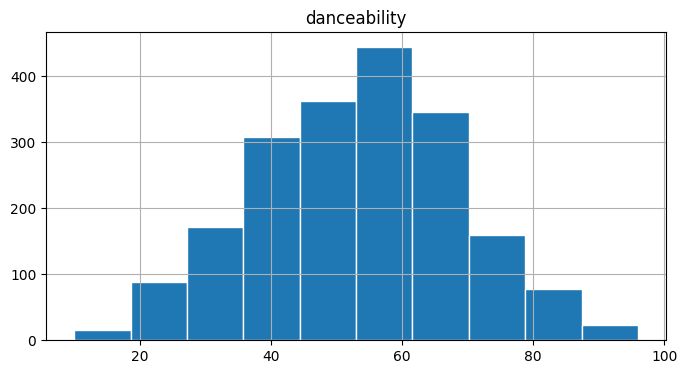

In [17]:
genre_dance.hist('danceability', edgecolor='w', figsize=(8,4))

In [18]:
genre_dance['danceability'].skew()

0.015471834815003006

As we can see from the histogram and the skew value, the distribution is very close to normal. This means we can confidently use the mean to get the average for danceability across all the genres.

In [19]:
genre_dance.agg({'danceability' : ['mean', 'median', 'std']})

,danceability
mean,53.238215
median,53.000000
std,15.351507


The average danceability of all the songs in the dataset is a value of **53.24**.

Next, let's group all the records by genre, and take some summary statistics from them

In [20]:
genre_dance_summary = genre_dance.groupby('top_genre').agg({'danceability': ['skew', 'mean', 'median', 'std', 'count']})

genre_dance_summary.sort_values(('danceability', 'mean'), ascending=False).head(10)

danceability                                   
                                skew       mean median        std count
top_genre                                                              
contemporary vocal jazz          NaN  88.000000   88.0        NaN     1
reggae fusion              -0.182226  86.250000   86.5   8.180261     4
gangster rap                     NaN  85.000000   85.0        NaN     1
detroit hip hop            -0.566956  84.142857   87.0   9.352871     7
electronica                      NaN  79.000000   79.0        NaN     1
g funk                      0.141855  77.400000   77.0  12.136721     5
reggae                      0.559779  77.125000   75.5  10.920982     8
danish pop                       NaN  77.000000   77.0        NaN     1
rock-and-roll                    NaN  76.000000   76.0        NaN     1
diva house                       NaN  76.000000   76.0        NaN     1

As there are some genres in the dataset that are represented by one song only, they may not be a very good representation of other songs in that genre. So let's remove those first by using `.dropna()` to take out all the records with `NaN` values in the `std` and `skew` columns (They're `NaN` because they cannot compute without more than one value.)

In [21]:
genre_dance_summary.sort_values(('danceability', 'mean'), ascending=False).dropna().head(10)

danceability                                   
                           skew       mean median        std count
top_genre                                                         
reggae fusion         -0.182226  86.250000   86.5   8.180261     4
detroit hip hop       -0.566956  84.142857   87.0   9.352871     7
g funk                 0.141855  77.400000   77.0  12.136721     5
reggae                 0.559779  77.125000   75.5  10.920982     8
east coast hip hop    -1.014230  73.500000   76.5  13.967820     6
disco                 -0.516956  70.500000   69.0  12.152221    18
australian rock        1.293343  70.333333   69.0   4.163332     3
electro                0.597005  68.857143   61.0  16.945290     7
belgian pop           -1.424103  68.250000   71.5  12.093387     4
boy band               0.967214  67.666667   64.5  11.570076     6

Here, we can see the full list of song genres with more than one record. Note that the `skew` value was included in order to determine whether it would be more accurate to use the `mean` or `median` as the measure of central tendency.

From the results, we can see that `reggae fusion` has the highest average `danceability` value. However, it is only represented by a count of 4 songs. 

The next largest `danceability` average with a genre represented by >=10 songs would be `disco`. Because of its `skew` value of **-0.52**, the `median` may be more accurate to look at, with a value of **69.0**.

Now, let's take a look at the genre with the lowest average `danceability` value.

In [22]:
genre_dance_summary.sort_values(('danceability', 'mean'), ascending=True).dropna().head(10)

danceability                                   
                          skew       mean median        std count
top_genre                                                        
chanson              -0.201373  35.000000   35.0   6.082763     9
carnaval limburg      1.526787  35.200000   30.5  13.538423    10
dutch metal           0.319781  36.250000   34.5  12.841988     4
britpop              -1.463008  40.181818   43.0  12.623931    11
celtic                0.690697  40.800000   42.0  18.700267     5
bubblegum pop        -0.852358  41.000000   43.0  10.148892     3
glam metal           -0.319205  42.000000   45.0  11.084900    17
canadian folk         0.300439  43.857143   44.0  14.299517     7
modern folk rock     -0.266258  44.142857   48.0  12.850792     7
alternative metal     0.040908  45.742857   44.5  13.168568    70

From the DataFrame above, we can see that `chanson`, a lyric-driven French song genre, has the lowest mean `danceability`, with a value of **35.00**.

Let's take a look at the first 10 values sorted by `count` and see what the averages for the high-count genres are.

In [23]:
genre_dance_summary.sort_values(('danceability', 'count'), ascending=False).dropna().head(10)

danceability                                   
                          skew       mean median        std count
top_genre                                                        
album rock           -0.003513  51.411622   52.0  14.451125   413
adult standards      -0.018742  49.162602   49.0  16.363381   123
dutch pop             0.020051  51.147727   51.0  15.013817    88
alternative rock      0.009093  48.534884   47.5  13.884988    86
dance pop            -0.515789  60.650602   64.0  14.334364    83
dutch indie          -0.373096  53.400000   54.0  12.355106    75
alternative metal     0.040908  45.742857   44.5  13.168568    70
dance rock           -0.276031  57.903846   58.5  13.137672    52
dutch cabaret         0.447093  54.137255   53.0  16.230859    51
classic rock         -0.294344  54.235294   58.0  16.320035    51

As we can see, `album rock` with the highest song count has a mean of **51.41**. `dance pop`, rather appropriately, has a relatively high danceability median of **64.0**.

## Which Attributes and Sound Features are Correlated?

To this, we first slice the dataframe and only incorporate the different sound features per top_genre and their mean. Afterwards, we apply panda's **.corr()** function to get the correlation value between them.


In [24]:
genre_attributes = df.copy()
genre_attributes.drop(['index','period','artist','popularity','title','year'], axis=1, inplace=True)
genre_attributes_summary = genre_attributes.groupby('top_genre').agg('mean')
genre_attributes_summary.dropna()
genre_attributes_summary.corr()

,bpm,energy,danceability,loudness,liveness,valence,length,acousticness,speechiness
bpm,1.000000,0.172462,-0.141669,0.062181,0.162355,0.052995,0.138210,-0.042385,0.034224
energy,0.172462,1.000000,0.188497,0.762626,0.203286,0.300656,0.030239,-0.687878,0.267247
danceability,-0.141669,0.188497,1.000000,0.052810,-0.015855,0.499296,-0.000552,-0.225136,0.309446
loudness,0.062181,0.762626,0.052810,1.000000,0.031111,0.090537,-0.101308,-0.501563,0.239981
liveness,0.162355,0.203286,-0.015855,0.031111,1.000000,0.050215,-0.016061,-0.052157,0.110266
valence,0.052995,0.300656,0.499296,0.090537,0.050215,1.000000,-0.234040,-0.082796,0.163477
length,0.138210,0.030239,-0.000552,-0.101308,-0.016061,-0.234040,1.000000,-0.213287,-0.105329
acousticness,-0.042385,-0.687878,-0.225136,-0.501563,-0.052157,-0.082796,-0.213287,1.000000,-0.172209
speechiness,0.034224,0.267247,0.309446,0.239981,0.110266,0.163477,-0.105329,-0.172209,1.000000


It has been found that there are a couple of sound features that have correlation between them, such as `energy` and `loudness` which have a positive correlation between them. Let's take a look at the scatterplot for these features.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='energy', ylabel='loudness'>

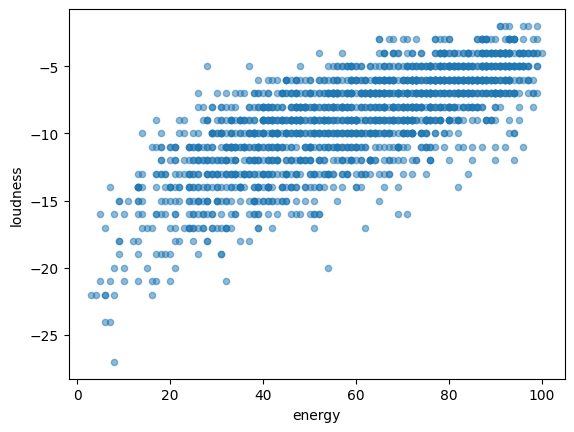

In [25]:
genre_attributes[['energy', 'loudness']].plot.scatter(x='energy', y='loudness', alpha=0.5)

As you can see, there is a distinct upwards trend, denoting a positive correlation. This means that, usually, the louder the song is, the more energy it's perceived to have.

Another one is `acousticness` and `energy` with a negative correlation. Let's see the scatterplot for these two.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='acousticness', ylabel='energy'>

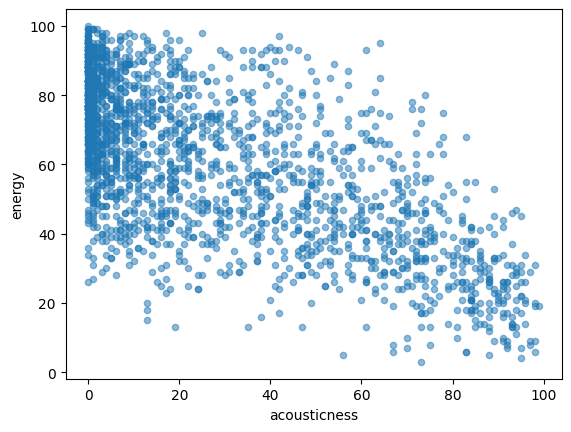

In [26]:
genre_attributes[['acousticness', 'energy']].plot.scatter(x='acousticness', y='energy', alpha=0.5)

Given this negative correlation, we can say that the perceived energy in a song tends to lower the more it uses more acoustic elements or instruments rather than more electronic elements.

 `acousticness` and `loudness` also have a negative correlation between them. Let's see the scatterplot.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='acousticness', ylabel='loudness'>

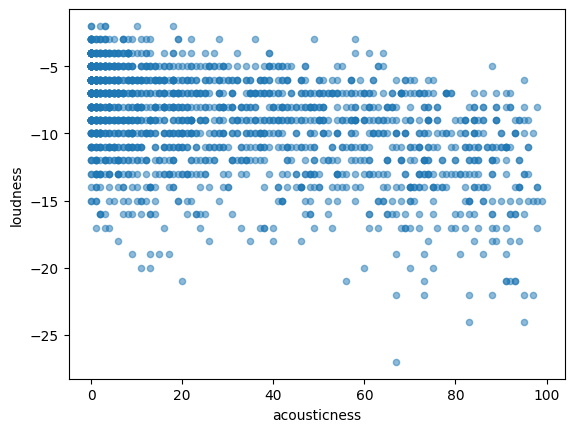

In [27]:
genre_attributes[['acousticness', 'loudness']].plot.scatter(x='acousticness', y='loudness', alpha=0.5)

From this, similar to the relationship between `acousticness` and `loudness`, the more acoustic elements there are in a song, the more it tends to be louder. This could be because most acoustic instruments are usually limited in terms of how loud a sound they can produce.

Lastly, there is a slightly positive correlation between `valence` and `danceability`.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='valence', ylabel='danceability'>

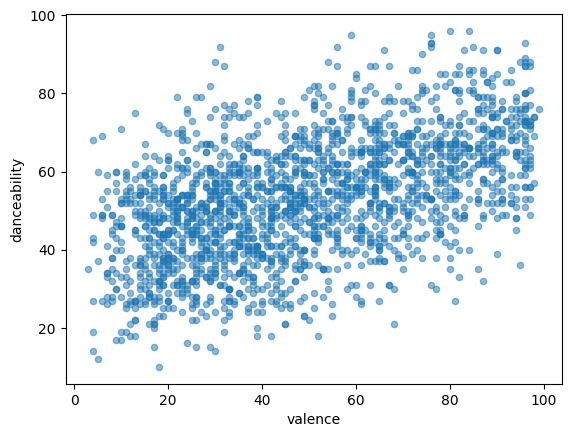

In [28]:
genre_attributes[['valence', 'danceability']].plot.scatter(x='valence', y='danceability', alpha=0.5)

We can infer from this that danceable songs tend to be "happier" sounding.

## What are the energy level intervals of all the songs in the dataset?

To answer this question, the variables of interest are:
- **`energy`**: Scale measuring how energetic and upbeat the track is. The higher the value, the more energetic.

Since the sample population is independent and is at least 30, the group will find the confidence interval of the energy level of the songs in the dataset.

First, let's take a look if the distribution of values in energy is normal.

In [29]:
df['energy'].skew()

-0.24811841442289234

Since the value is negative but still close to zero, it can be said that the distribution is slightly negatively skewed. Let's validate this using a histogram.

array([[<AxesSubplot: title={'center': 'energy'}>]], dtype=object)

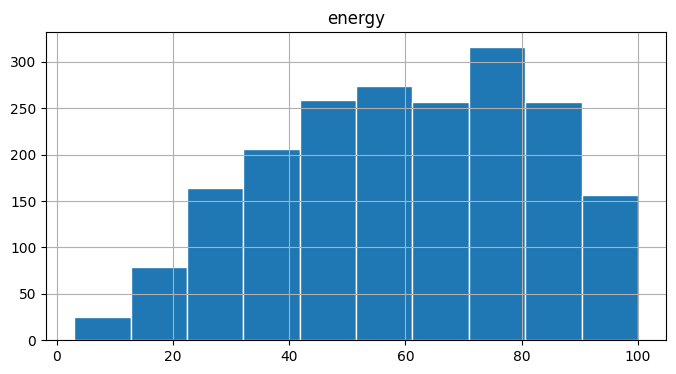

In [30]:
df.hist('energy', edgecolor='w', figsize=(8,4))

With this, it can be said that the sample is approximately symmetric.

Now, let's take a look at energy's mean, meadian, and standard deviation to get the confidence interval.

In [31]:
energy_agg = df.agg({"energy": ["mean", "median", "std"]})

sample_mean = energy_agg.loc["mean"][0]
sample_median = energy_agg.loc["median"][0]
sample_std = energy_agg.loc["std"][0]

energy_agg

,energy
mean,59.679539
median,61.000000
std,22.154322


The mean, median, and standard deviation are: **59.68**, **61.00**, and **22.15**.

## Confidence Interval

A confidence interval for a population mean is of the following form:

$$\bar{x} \pm z^* \frac{s}{\sqrt{n}}$$

Where $z^*$, also known as the **critical value**, is the z-score that corresponds to the middle 95% of the data.

The z-score of a 95% confidence is **1.96**. Let's validate the critical value of a 95% confidence interval using the formula below. 

In [32]:
z_star_95 = norm.ppf(0.975)
print('{:.2f}'.format(z_star_95))

1.96


## Margin of Error

We can compute the **margin of error** using the formula

$$z^* \frac{s}{\sqrt{n}}$$

Compute and display the margin of error given a 95% confidence level.

In [33]:
n = df['index'].count()

margin_of_error = z_star_95 * (sample_std / np.sqrt(n))
print('Margin of Error: {:.2f}'.format(margin_of_error))

Margin of Error: 0.97


Now, let's compute for the 95% confidence interval of the dataset. The 95% confidence interval is the sample mean $\pm$ the margin of error. 

In [34]:
minimum_value = sample_mean - margin_of_error
maximum_value = sample_mean + margin_of_error
print('({:.2f},'.format(minimum_value), '{:.2f})'.format(maximum_value))

(58.71, 60.65)


With this, even though we do not have the complete list of the popular songs of spotify, we are 95% confident that the true average energy level is between **58.71** to **60.65**.

# Research Question

Based on the results of our EDAs, we found that the `danceability` feature had varying averages across different genres, with some genres having similar averages. This leads us to question whether we could possibly find similar average values for other song features across genres, and find out how many features between certain genres are similar.

We also found evidence that a couple of sound features had relationships between them. These correlations lead us to believe that these sound features could possibly be utilized to find relationships and similarities between the different genres as well.

We also discovered that the the 95% confidence interval for all the songs across all genres in the dataset was between 58.71 and 60.65. To find out if certain genres are similar from another, it would be important to look at their confidence interval. If the intervals overlap, it can be said that the difference between them are not statistically significant.

Given all of this information we've acquired about our dataset, we have decided on the research question, **"Based on the attributes and features of songs, which music genres are similar (or dissimilar) to one another?"**

Music is arguably one of mankind's most significant innovations as it is able to transcend past the visual barriers and limitations by stimulating our imagination and emotions through sound. From Beethoven's Waldstein, to Tupac's All Eyez on Me, to Taylor Swift's Midnight Rain; each and every one of these songs from completely different genre's are able to tell different stories and provoke different emotions. With that said, given the amount of songs and genres available, it can be quite difficult to find the right songs given a certain taste in music. 

Being able to know which genres go well or are similar with others can definitely help the selection and filtration process. The group plans to answer this question with the use of cossine similarity and data mining techniques, such as clustering, using the given sound feature data per genre. The resulting data may also be used in recommender systems for music platforms, much like Spotify, to boost their efficiency by manipulating the algorithm into looking for suggestions from genres in the same or closest clusters first, instead of searching for recommendations randomly across the different genres.

# Phase 2

## Data Modelling

In order to answer our research question, we will employ the use of k-means clustering. Through clustering, we'll be able to see which genres are clustered together, along with how many songs of each genre there are in each cluster.

First, let's take a look at our DataFrame again.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         1994 non-null   int64   
 1   title         1994 non-null   string  
 2   artist        1994 non-null   string  
 3   top_genre     1994 non-null   string  
 4   period        1994 non-null   category
 5   year          1994 non-null   int64   
 6   bpm           1994 non-null   int64   
 7   energy        1994 non-null   int64   
 8   danceability  1994 non-null   int64   
 9   loudness      1994 non-null   int64   
 10  liveness      1994 non-null   int64   
 11  valence       1994 non-null   int64   
 12  length        1994 non-null   int64   
 13  acousticness  1994 non-null   int64   
 14  speechiness   1994 non-null   int64   
 15  popularity    1994 non-null   int64   
dtypes: category(1), int64(12), string(3)
memory usage: 236.1 KB


For clustering, we'll only need a few of the columns; mainly those that have to do with the musical and emotional attributes of songs. In this case, we'll take the columns of `bpm`, `energy`, `danceability`, `loudness`, `liveness`, `valence`, `acousticness`, `speechiness` into account, as well as the `top_genre` column which will be used to categorize the songs.

`length` was not taken into account because 1) there are some outlier songs with abnormally long durations that may affect our clustering results, and 2) we believe that length isn't necessarily indicative of a song's musical qualities.

In [36]:
genre_df = df[["bpm", "energy", "danceability", "loudness", "liveness", "valence", "acousticness", "speechiness", "top_genre"]].copy()
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   bpm           1994 non-null   int64 
 1   energy        1994 non-null   int64 
 2   danceability  1994 non-null   int64 
 3   loudness      1994 non-null   int64 
 4   liveness      1994 non-null   int64 
 5   valence       1994 non-null   int64 
 6   acousticness  1994 non-null   int64 
 7   speechiness   1994 non-null   int64 
 8   top_genre     1994 non-null   string
dtypes: int64(8), string(1)
memory usage: 140.3 KB


In order for our KMeans code to work, we have to set `top_genre`'s datatype to an object.

In [37]:
genre_df['top_genre'] = genre_df['top_genre'].astype('object');
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   bpm           1994 non-null   int64 
 1   energy        1994 non-null   int64 
 2   danceability  1994 non-null   int64 
 3   loudness      1994 non-null   int64 
 4   liveness      1994 non-null   int64 
 5   valence       1994 non-null   int64 
 6   acousticness  1994 non-null   int64 
 7   speechiness   1994 non-null   int64 
 8   top_genre     1994 non-null   object
dtypes: int64(8), object(1)
memory usage: 140.3+ KB


Now, in order for us to select a good value for `k`, we'll use the elbow method. The following code for visualizing the line graph for the elbow method was adapted from [Geeks for Geeks](https://www.geeksforgeeks.org/determining-the-number-of-clusters-in-data-mining/).


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


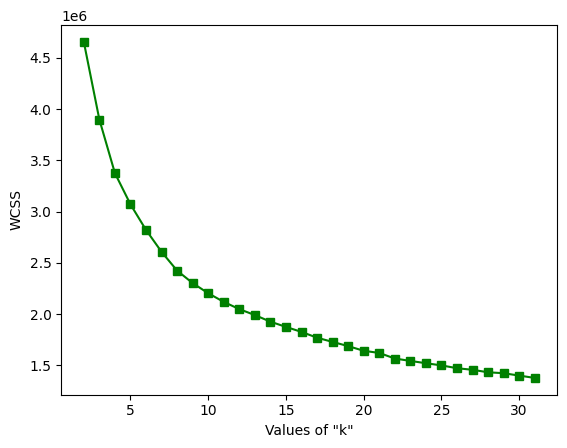

In [38]:
import sys
!{sys.executable} -m pip install scikit-learn
import sklearn
from sklearn.cluster import KMeans


# determining the maximum number of clusters
# using the simple method
dataset = genre_df.drop(columns=["top_genre"]).copy()

limit = int((dataset.shape[0]//2)**0.5)
 
# selecting optimal value of 'k'
# using elbow method
 
# wcss - within cluster sum of
# squared distances
wcss = {}
 
for k in range(2,limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset)
    wcss[k] = model.inertia_
     
# plotting the wcss values
# to find out the elbow value
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

From the plot, we can see that the average distances of each data point for each cluster seems to stabilize around `k = 7`. As such, we'll use `k = 7` as our number of clusters.

We then import our own KMeans functions, which we also used for our CSMODEL notebooks.

In [39]:
from kmeans import KMeans

In [40]:
kmeans = KMeans(7, 0, 8, 1994, genre_df)

We first have to initialize the centroids for our dataset.

In [41]:
kmeans.initialize_centroids(genre_df)

Z:\CSMODEL\Untitled Folder\kmeans.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.centroids = self.centroids.append(point, ignore_index=True)
Z:\CSMODEL\Untitled Folder\kmeans.py:133: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.centroids = self.centroids.append(point, ignore_index=True)
Z:\CSMODEL\Untitled Folder\kmeans.py:133: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.centroids = self.centroids.append(point, ignore_index=True)
Z:\CSMODEL\Untitled Folder\kmeans.py:133: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.centroids = self.centroids.append(point, ignore_index=True)
Z:\CSMODEL\Untitled Folder\kmeans

,bpm,energy,danceability,loudness,liveness,valence,acousticness,speechiness
0,175,66,39,-6,6,46,28,3
1,37,25,27,-12,9,13,80,4
2,91,82,67,-7,97,80,10,5
3,132,29,54,-10,71,19,97,3
4,102,25,96,-13,4,80,16,6
5,174,92,55,-11,99,11,1,7
6,84,79,10,-4,36,18,0,4


Then, we use the `train()` function from our Python file, which is the main function for processing the clusters.

In [42]:
groups = kmeans.train(genre_df, 300)


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Done clustering!


,bpm,energy,danceability,loudness,liveness,valence,acousticness,speechiness
group,,,,,,,,
0,159.292763,71.256579,43.677632,-7.365132,17.467105,43.322368,10.052632,5.947368
1,90.050420,31.411765,46.705882,-12.050420,15.655462,28.827731,72.159664,4.264706
2,117.963203,73.984848,65.261905,-7.950216,15.242424,76.783550,9.463203,5.361472
3,144.085586,35.094595,44.162162,-11.536036,15.770270,29.427928,66.202703,3.819820
4,112.884120,56.472103,63.300429,-9.725322,15.918455,67.978541,50.171674,4.901288
5,118.594340,74.339623,53.103774,-7.641509,71.613208,58.207547,21.056604,6.537736
6,103.715618,62.594406,49.953380,-8.265734,16.389277,33.738928,10.074592,4.608392


Now, using `print_results()`, we can see the final clusters that were generated.

In [43]:
test=kmeans.print_results(groups[0], -1, genre_df)

Number of data points in each cluster:
Cluster 0:
Genre adult standards:	 7
Genre album rock:	 59
Genre alternative hip hop:	 1
Genre alternative metal:	 24
Genre classic rock:	 5
Genre alternative pop rock:	 1
Genre pop:	 4
Genre modern rock:	 16
Genre detroit hip hop:	 1
Genre alternative rock:	 15
Genre dutch indie:	 10
Genre garage rock:	 1
Genre dutch cabaret:	 5
Genre permanent wave:	 11
Genre classic uk pop:	 2
Genre dance pop:	 7
Genre modern folk rock:	 4
Genre dutch pop:	 25
Genre alternative dance:	 5
Genre german pop:	 3
Genre afropop:	 1
Genre british soul:	 4
Genre irish rock:	 10
Genre disco:	 1
Genre art rock:	 4
Genre neo mellow:	 1
Genre britpop:	 5
Genre carnaval limburg:	 3
Genre british folk:	 1
Genre celtic rock:	 2
Genre east coast hip hop:	 1
Genre dutch rock:	 1
Genre blues rock:	 1
Genre electro:	 1
Genre belgian rock:	 1
Genre reggae fusion:	 1
Genre british invasion:	 3
Genre canadian pop:	 1
Genre dutch hip hop:	 1
Genre dutch prog:	 2
Genre trance:	 1
Genr

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre new wave pop:	 1
Genre classic italian pop:	 1


Cluster 1:
Genre adult standards:	 35
Genre album rock:	 34
Genre alternative metal:	 3
Genre classic rock:	 8
Genre alternative pop rock:	 1
Genre pop:	 12
Genre modern rock:	 1
Genre alternative rock:	 4
Genre dutch indie:	 16
Genre dutch cabaret:	 10
Genre permanent wave:	 4
Genre classic uk pop:	 2
Genre dance pop:	 6
Genre dutch pop:	 13
Genre dutch americana:	 2
Genre german pop:	 2
Genre british soul:	 7
Genre irish rock:	 2
Genre art rock:	 2
Genre neo mellow:	 5
Genre britpop:	 1
Genre carnaval limburg:	 2
Genre arkansas country:	 3
Genre celtic:	 1
Genre chanson:	 3
Genre hip pop:	 1
Genre dutch rock:	 4
Genre blues rock:	 3
Genre australian pop:	 3
Genre belgian rock:	 2
Genre downtempo:	 1
Genre british invasion:	 3
Genre canadian pop:	 3
Genre bow pop:	 1
Genre dutch hip hop:	 3
Genre acoustic pop:	 1
Genre operatic pop:	 1
Genre mellow gold:	 2
Genre dance rock:	 2
Genre canadian folk:	 3
Genre art pop:	 4
Genre uk po

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre cyberpunk:	 1
Genre motown:	 1


Cluster 2:
Genre adult standards:	 24
Genre album rock:	 107
Genre alternative metal:	 11
Genre classic rock:	 15
Genre alternative pop rock:	 2
Genre pop:	 14
Genre modern rock:	 10
Genre detroit hip hop:	 5
Genre alternative rock:	 23
Genre dutch indie:	 20
Genre garage rock:	 2
Genre dutch cabaret:	 7
Genre permanent wave:	 3
Genre classic uk pop:	 5
Genre dance pop:	 31
Genre dutch pop:	 14
Genre dutch americana:	 2
Genre alternative dance:	 2
Genre german pop:	 1
Genre british soul:	 8
Genre irish rock:	 7
Genre disco:	 12
Genre big room:	 1
Genre art rock:	 15
Genre neo mellow:	 1
Genre boy band:	 1
Genre carnaval limburg:	 1
Genre arkansas country:	 1
Genre celtic rock:	 1
Genre east coast hip hop:	 3
Genre dutch rock:	 4
Genre blues rock:	 2
Genre electro:	 3
Genre australian pop:	 1
Genre belgian rock:	 1
Genre reggae fusion:	 2
Genre british invasion:	 6
Genre dutch hip hop:	 4
Genre dutch metal:	 1
Genre acid jazz:	 1
Genre dutch prog:	

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre glam metal:	 5
Genre brill building pop:	 1
Genre belgian pop:	 2
Genre classic schlager:	 1
Genre indie pop:	 2
Genre australian rock:	 1
Genre nederpop:	 1
Genre folk-pop:	 1
Genre metropopolis:	 2
Genre australian dance:	 1
Genre australian psych:	 2
Genre glam rock:	 8
Genre baroque pop:	 1
Genre chicago soul:	 1
Genre classic soul:	 1
Genre europop:	 9
Genre reggae:	 4
Genre funk:	 6
Genre folk:	 2
Genre basshall:	 1
Genre australian alternative rock:	 1
Genre yacht rock:	 1
Genre new wave pop:	 1
Genre gangster rap:	 1
Genre diva house:	 1


Cluster 3:
Genre adult standards:	 25
Genre album rock:	 47
Genre alternative metal:	 5
Genre classic rock:	 4
Genre pop:	 5
Genre modern rock:	 3
Genre alternative rock:	 3
Genre dutch indie:	 5
Genre dutch cabaret:	 10
Genre permanent wave:	 7
Genre classic uk pop:	 5
Genre dance pop:	 9
Genre dutch pop:	 12
Genre dutch americana:	 2
Genre german pop:	 2
Genre british soul:	 5
Genre art rock:	 5
Genre danish pop rock:	 1
Genre neo mel

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre classic soul:	 1
Genre bubblegum pop:	 1
Genre classic country pop:	 2
Genre europop:	 3
Genre folk:	 3
Genre alternative country:	 1
Genre christelijk:	 2
Genre classical rock:	 1
Genre latin jazz:	 1
Genre bebop:	 1


Cluster 4:
Genre adult standards:	 22
Genre album rock:	 56
Genre alternative metal:	 1
Genre classic rock:	 11
Genre alternative pop rock:	 2
Genre pop:	 6
Genre alternative rock:	 3
Genre dutch indie:	 9
Genre dutch cabaret:	 12
Genre permanent wave:	 1
Genre classic uk pop:	 2
Genre dance pop:	 3
Genre dutch pop:	 8
Genre dutch americana:	 2
Genre british soul:	 3
Genre disco:	 3
Genre art rock:	 3
Genre neo mellow:	 1
Genre boy band:	 1
Genre arkansas country:	 4
Genre latin alternative:	 1
Genre celtic:	 1
Genre chanson:	 2
Genre dutch rock:	 4
Genre blues rock:	 6
Genre australian pop:	 2
Genre reggae fusion:	 1
Genre british invasion:	 10
Genre bow pop:	 1
Genre dutch hip hop:	 2
Genre acoustic pop:	 1
Genre mellow gold:	 1
Genre dance rock:	 6
Genre blues:

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre celtic punk:	 1
Genre levenslied:	 1
Genre german pop rock:	 1


Cluster 5:
Genre adult standards:	 4
Genre album rock:	 17
Genre alternative hip hop:	 1
Genre alternative metal:	 2
Genre classic rock:	 3
Genre pop:	 2
Genre modern rock:	 3
Genre detroit hip hop:	 1
Genre alternative rock:	 7
Genre dutch indie:	 3
Genre dutch cabaret:	 2
Genre dance pop:	 4
Genre dutch pop:	 5
Genre dutch americana:	 1
Genre alternative dance:	 1
Genre irish rock:	 4
Genre disco:	 2
Genre art rock:	 4
Genre britpop:	 1
Genre carnaval limburg:	 1
Genre arkansas country:	 1
Genre chanson:	 2
Genre east coast hip hop:	 2
Genre dutch rock:	 2
Genre blues rock:	 1
Genre australian pop:	 1
Genre belgian rock:	 2
Genre british invasion:	 5
Genre dutch hip hop:	 1
Genre dance rock:	 6
Genre blues:	 1
Genre big beat:	 1
Genre g funk:	 1
Genre happy hardcore:	 1
Genre glam rock:	 2
Genre classic country pop:	 1
Genre europop:	 1
Genre hard rock:	 1
Genre reggae:	 2
Genre funk:	 2
Genre christelijk:	 1
Genr

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre art rock:	 7
Genre danish pop rock:	 1
Genre neo mellow:	 1
Genre britpop:	 3
Genre boy band:	 4
Genre carnaval limburg:	 1
Genre chanson:	 2
Genre celtic rock:	 4
Genre dutch rock:	 3
Genre blues rock:	 1
Genre electro:	 3
Genre australian pop:	 1
Genre belgian rock:	 2
Genre downtempo:	 3
Genre british invasion:	 5
Genre finnish metal:	 2
Genre dutch metal:	 3
Genre soft rock:	 1
Genre acoustic pop:	 1
Genre dutch prog:	 2
Genre candy pop:	 1
Genre scottish singer-songwriter:	 1
Genre mellow gold:	 3
Genre dance rock:	 8
Genre blues:	 1
Genre big beat:	 3
Genre art pop:	 4
Genre glam metal:	 6
Genre brill building pop:	 2
Genre g funk:	 4
Genre belgian pop:	 2
Genre classic schlager:	 2
Genre contemporary country:	 2
Genre barbadian pop:	 1
Genre chamber pop:	 2
Genre british singer-songwriter:	 1
Genre australian rock:	 2
Genre folk-pop:	 3
Genre electropop:	 2
Genre edm:	 3
Genre irish pop:	 1
Genre stomp and holler:	 1
Genre contemporary vocal jazz:	 1
Genre glam rock:	 15
G

Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

Genre indie anthem-folk:	 1
Genre baroque pop:	 1
Genre classic soul:	 2
Genre bubblegum pop:	 1
Genre europop:	 5
Genre j-core:	 1
Genre funk:	 2
Genre folk:	 3
Genre classic canadian rock:	 1
Genre canadian rock:	 1
Genre british alternative rock:	 2
Genre german alternative rock:	 1


    Cluster                     Genre Count
0         0           adult standards     7
1         0                album rock    59
2         0       alternative hip hop     1
3         0         alternative metal    24
4         0              classic rock     5
..      ...                       ...   ...
419       6                      folk     3
420       6     classic canadian rock     1
421       6             canadian rock     1
422       6  british alternative rock     2
423       6   german alternative rock     1

[424 rows x 3 columns]


Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'Cluster' : i, 'Genre' : genre, 'Count' : cluster.loc[cluster['top_genre'] == genre].shape[0]}, ignore_index = True)
Z:\CSMODEL\Untitled Folder\kmeans.py:55: FutureWarning: The frame.append method

After running the K-Means clustering algorithm on the dataset through 32 iterations, we've finished with 7 different clusters. Let's explore them each individually

Normally, we would visualize the clustered result on a plotted axis, however, due to its multidimensionality, we found it very difficult and inefficient to do so. Instead, we've decided to analyze the clustering results both per cluster, and per genre.

**Analysis Per Cluster**


Let's first analyze the different genres per cluster and see which genres dominate which clusters.

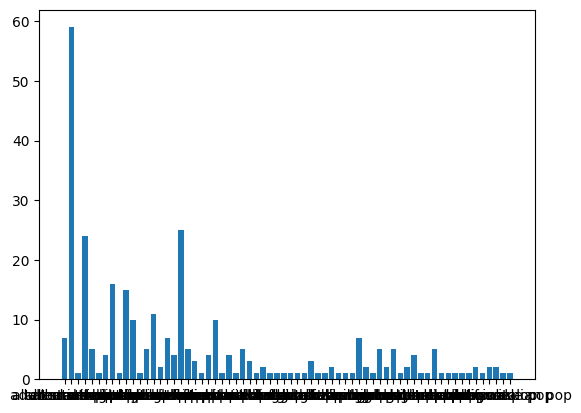

In [44]:
import matplotlib.pyplot as plt
plt.bar(test.loc[test['Cluster']==0]['Genre'],test.loc[test['Cluster']==0]['Count'])
plt.show()

In [53]:
pd.set_option('display.max_rows', 100)
test.loc[test['Cluster']==0].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
1,0,album rock,59
17,0,dutch pop,25
3,0,alternative metal,24
7,0,modern rock,16
9,0,alternative rock,15
13,0,permanent wave,11
22,0,irish rock,10
10,0,dutch indie,10
43,0,dance rock,7
15,0,dance pop,7


As we can see from the results, Cluster 0 is mostly dominated by `Rock` and `Metal` genres such as `Album Rock` ,`Alternative Metal`, `Modern Rock`, and `Alternative Rock` to name a few.

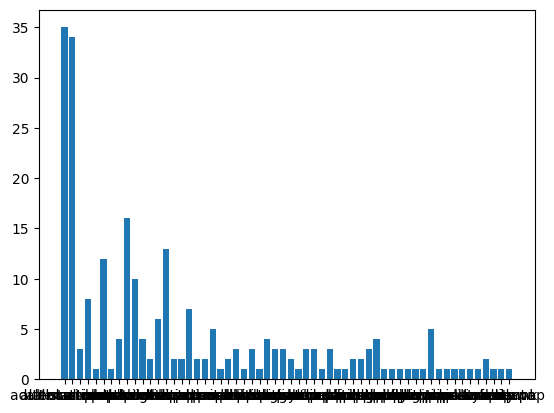

In [48]:
plt.bar(test.loc[test['Cluster']==1]['Genre'],test.loc[test['Cluster']==1]['Count'])
plt.show()

In [49]:
test.loc[test['Cluster']==1].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
66,1,adult standards,35
67,1,album rock,34
74,1,dutch indie,16
79,1,dutch pop,13
71,1,pop,12
75,1,dutch cabaret,10
69,1,classic rock,8
82,1,british soul,7
78,1,dance pop,6
85,1,neo mellow,5


As we can see from the results, Cluster 1 is mostly dominated by `Rock` and `Pop` genres such as `Pop` ,`Dutch Pop`, and `Album Rock`. It was also topped by `Adult Standards`.

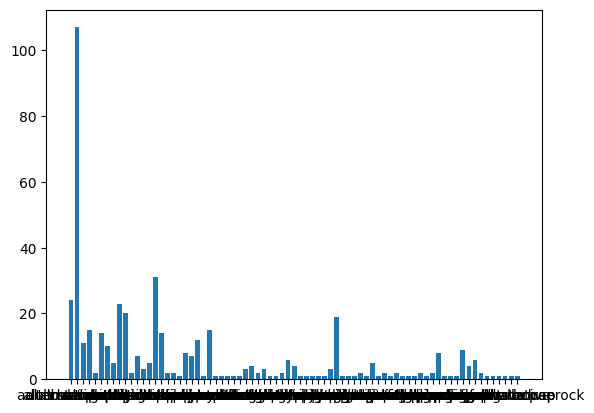

In [51]:
plt.bar(test.loc[test['Cluster']==2]['Genre'],test.loc[test['Cluster']==2]['Count'])
plt.show()

In [54]:
test.loc[test['Cluster']==2].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
125,2,album rock,107
138,2,dance pop,31
124,2,adult standards,24
132,2,alternative rock,23
133,2,dutch indie,20
168,2,dance rock,19
127,2,classic rock,15
147,2,art rock,15
129,2,pop,14
139,2,dutch pop,14


Cluster 2 was dominated by `album Rock` followed by `dance pop` and `adult standards`.

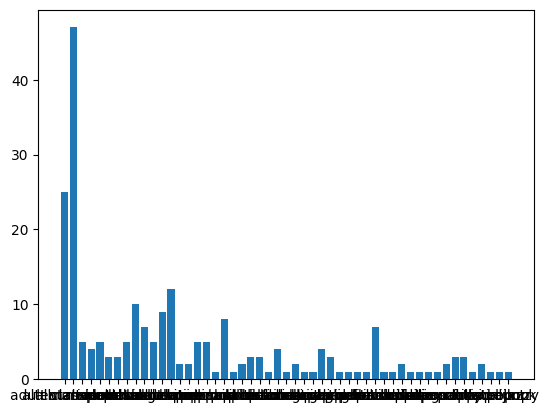

In [56]:
plt.bar(test.loc[test['Cluster']==3]['Genre'],test.loc[test['Cluster']==3]['Count'])
plt.show()

In [57]:
test.loc[test['Cluster']==3].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
200,3,album rock,47
199,3,adult standards,25
211,3,dutch pop,12
207,3,dutch cabaret,10
210,3,dance pop,9
217,3,neo mellow,8
234,3,glam rock,7
208,3,permanent wave,7
209,3,classic uk pop,5
214,3,british soul,5


A majority of `Cluster 3` also consisted of `album rock` and `adult standards`.

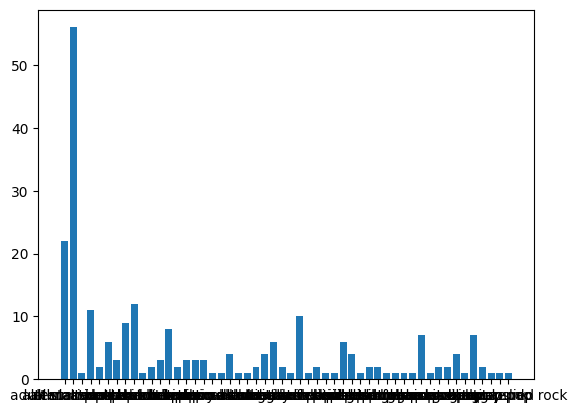

In [58]:
plt.bar(test.loc[test['Cluster']==4]['Genre'],test.loc[test['Cluster']==4]['Count'])
plt.show()

In [59]:
test.loc[test['Cluster']==4].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
251,4,album rock,56
250,4,adult standards,22
258,4,dutch cabaret,12
253,4,classic rock,11
277,4,british invasion,10
257,4,dutch indie,9
262,4,dutch pop,8
297,4,europop,7
291,4,glam rock,7
255,4,pop,6


A majority of `Cluster 4` also consisted of `album rock` and `adult standards` yet again.

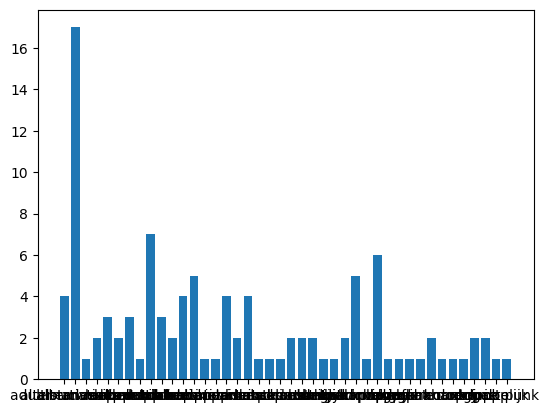

In [60]:
plt.bar(test.loc[test['Cluster']==5]['Genre'],test.loc[test['Cluster']==5]['Count'])
plt.show()

In [62]:
test.loc[test['Cluster']==5].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
303,5,album rock,17
310,5,alternative rock,7
331,5,dance rock,6
314,5,dutch pop,5
329,5,british invasion,5
302,5,adult standards,4
317,5,irish rock,4
313,5,dance pop,4
319,5,art rock,4
308,5,modern rock,3


`Cluster 5` also largely consisted of `album rock` and `alternative rock` but to a relatively lesser extent.

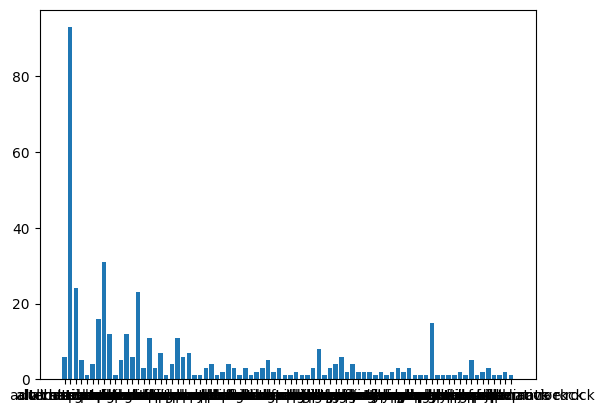

In [64]:
plt.bar(test.loc[test['Cluster']==6]['Genre'],test.loc[test['Cluster']==6]['Count'])
plt.show()

In [65]:
test.loc[test['Cluster']==6].sort_values(by='Count', ascending=False)

,Cluster,Genre,Count
345,6,album rock,93
351,6,alternative rock,31
346,6,alternative metal,24
357,6,dance pop,23
350,6,modern rock,16
409,6,glam rock,15
352,6,dutch indie,12
355,6,permanent wave,12
359,6,dutch pop,11
364,6,irish rock,11


Lastly, `Cluster 6` was topped by `album rock` and `alternative rock`

Let's have a look at the summary of sound features per cluster by taking the last set of centroids used by the K-Means Algorithm. This will help us get a better idea of the basis and similarities used by the algorithm to cluster these songs.

In [66]:
groups[1]

,bpm,energy,danceability,loudness,liveness,valence,acousticness,speechiness
group,,,,,,,,
0,159.292763,71.256579,43.677632,-7.365132,17.467105,43.322368,10.052632,5.947368
1,90.050420,31.411765,46.705882,-12.050420,15.655462,28.827731,72.159664,4.264706
2,117.963203,73.984848,65.261905,-7.950216,15.242424,76.783550,9.463203,5.361472
3,144.085586,35.094595,44.162162,-11.536036,15.770270,29.427928,66.202703,3.819820
4,112.884120,56.472103,63.300429,-9.725322,15.918455,67.978541,50.171674,4.901288
5,118.594340,74.339623,53.103774,-7.641509,71.613208,58.207547,21.056604,6.537736
6,103.715618,62.594406,49.953380,-8.265734,16.389277,33.738928,10.074592,4.608392


We can see here that `Cluster 0` mostly consisted of songs that had relatively high `bpm`,`energy`, `loudness`, and `speechiness`, while also having relatively low `acousticness`. Songs from `Cluster 1`, on the other hand, tend to have lower `bpm`, `energy`, `loudness`, `liveness`, `valence`, and `speechiness`, while having the highest `acousticness` among the clusters. `Cluster 2`'s Songs had relatively high `energy`, `danceability`, and `valence`, while also having really low `acousticness`. Songs from `Cluster 3` had high `bpm`, `acousticness`, while having low `energy`, `danceability`,`loudness`, `valence` and `speechiness`. `Cluster 4`'s songs had high `danceability`, and `valence`, while having pretty average values in the rest of the sound features. `Cluster 5`'s songs had the highest `energy`, relatively high `loudness`, `liveness`, and `speechiness`, while having average values elsewhere. Lastly, `Cluster 6` had low  `bpm`, and average values elsewhere.

**Analysis Per Genre**

Due to the wide variety of different genres, we'll only be looking at and analyzing the Top 3 Genres with the higest count of tracks.

In [76]:
print(df['top_genre'].value_counts())

album rock              413
adult standards         123
dutch pop                88
alternative rock         86
dance pop                83
                       ... 
happy hardcore            1
australian americana      1
electro house             1
afropop                   1
bebop                     1
Name: top_genre, Length: 149, dtype: Int64


Let's first look at the genre `Album Rock`

In [74]:
test.loc[test["Genre"]=="album rock"]

,Cluster,Genre,Count
1,0,album rock,59
67,1,album rock,34
125,2,album rock,107
200,3,album rock,47
251,4,album rock,56
303,5,album rock,17
345,6,album rock,93


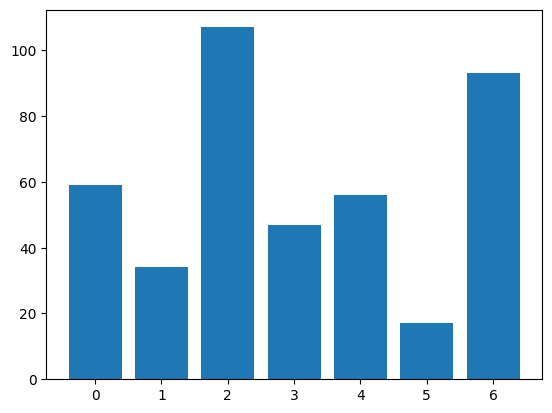

In [75]:
plt.bar(test.loc[test["Genre"]=="album rock"]['Cluster'],test.loc[test["Genre"]=="album rock"]['Count'])
plt.show()

In [73]:
print(df['top_genre'].value_counts())

album rock              413
adult standards         123
dutch pop                88
alternative rock         86
dance pop                83
                       ... 
happy hardcore            1
australian americana      1
electro house             1
afropop                   1
bebop                     1
Name: top_genre, Length: 149, dtype: Int64


107 of the album rock tracks went to the `Cluster 2`, making it the most prominent Cluster for the genre. It was least prominent in `Cluster 5`

Next, let's look at `Adult Standards`

In [77]:
test.loc[test["Genre"]=="adult standards"]

,Cluster,Genre,Count
0,0,adult standards,7
66,1,adult standards,35
124,2,adult standards,24
199,3,adult standards,25
250,4,adult standards,22
302,5,adult standards,4
344,6,adult standards,6


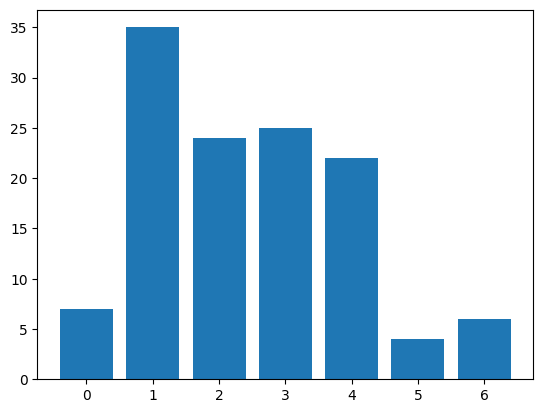

In [78]:
plt.bar(test.loc[test["Genre"]=="adult standards"]['Cluster'],test.loc[test["Genre"]=="adult standards"]['Count'])
plt.show()

Majority of songs belonging to the `adult standards` genre was grouped into `Cluster 1`. Songs from this genre were least prominent in `Cluster 5`

Lastly, let's look at `dutch pop`

In [79]:
test.loc[test["Genre"]=="dutch pop"]

,Cluster,Genre,Count
17,0,dutch pop,25
79,1,dutch pop,13
139,2,dutch pop,14
211,3,dutch pop,12
262,4,dutch pop,8
314,5,dutch pop,5
359,6,dutch pop,11


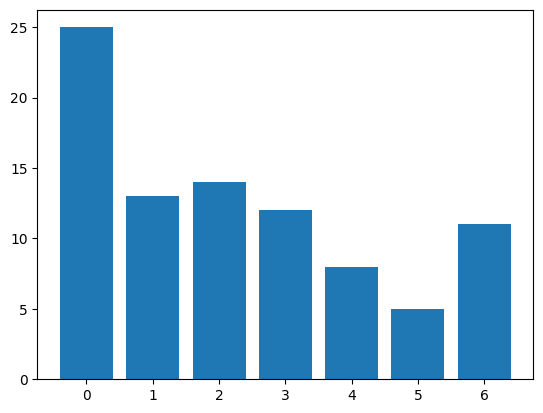

In [80]:
plt.bar(test.loc[test["Genre"]=="dutch pop"]['Cluster'],test.loc[test["Genre"]=="dutch pop"]['Count'])
plt.show()

`dutch pop` was most prominent in `Cluster 0` with 25 entries, and least prominent in `Cluster 5`.